In [23]:
# Combined script to convert a Moku FRA CSV to impedance, plot Nyquist/Bode, and fit a Randles model.
# It lets you choose a current range OR override kI directly.
#
# Usage example at the bottom runs on the user's uploaded CSV with range="10uA".
#
# Notes:
# - Each chart is on its own figure.
# - No explicit colors/styles are set (matplotlib defaults).
# - If SciPy is available, a nonlinear least-squares fit is used; otherwise a coarse fallback is used.

import os
import math
from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [24]:

# -----------------------------
# Configuration / Calibration
# -----------------------------
# Map your 263A current ranges to calibrated kI (A/V). Add more as you calibrate them.
CAL_KI = {
    "10uA": 1.0e-05,  # <-- user's measured calibration (A/V)
    "1uA":  1.0e-6,
    "100uA": 1.0e-4,
    "1mA":   1.0e-3,
    "10mA":  1.0e-2,
    "100mA": 1.0e-1,
}

def pick_kI(current_range: str | None, kI_override: float | None):
    """
    Choose kI (A/V) based on current_range key in CAL_KI or direct override.
    """
    if kI_override is not None:
        return float(kI_override), "override"
    if current_range is None:
        raise ValueError("Please provide current_range (e.g., '10uA') or kI_override.")
    if current_range not in CAL_KI or CAL_KI[current_range] in (None, float("nan")):
        raise ValueError(f"No calibrated kI for range='{current_range}'. "
                         f"Add it to CAL_KI or pass kI_override.")
    return float(CAL_KI[current_range]), current_range


In [25]:

# -----------------------------
# Parsing Moku FRA CSV
# -----------------------------
def load_moku_csv(csv_path: str) -> pd.DataFrame:
    """
    Robustly load a Moku FRA CSV (skips comment lines '%').
    Returns a DataFrame with columns:
      Frequency_Hz, Ch1_Mag_dB, Ch1_Phase_deg, Ch2_Mag_dB, Ch2_Phase_deg, Math_Mag_dB, Math_Phase_deg
    If Math columns are not present (all-NaN), they will remain NaN and we will compute the ratio from Ch1/Ch2.
    """
    with open(csv_path, "r", encoding="utf-8", errors="ignore") as f:
        data_lines = [ln for ln in f if not ln.strip().startswith("%") and ln.strip() != ""]
    # Try to read as 7-column numeric CSV (typical Moku export for two channels + Math)
    names7 = ["Frequency_Hz",
              "Ch1_Mag_dB", "Ch1_Phase_deg",
              "Ch2_Mag_dB", "Ch2_Phase_deg",
              "Math_Mag_dB", "Math_Phase_deg"]
    try:
        df = pd.read_csv(StringIO("".join(data_lines)), header=None, names=names7)
    except Exception:
        # Fallback: let pandas infer
        df = pd.read_csv(StringIO("".join(data_lines)))
        # Try to rename if likely order appears
        if df.shape[1] >= 7:
            df.columns = names7 + [f"Extra_{i}" for i in range(df.shape[1]-7)]
        else:
            raise

    return df

# -----------------------------
# Impedance computation
# -----------------------------
def db_to_linear_mag(dB):
    """20*log10(V) -> linear magnitude."""
    return 10.0 ** (np.asarray(dB) / 20.0)

def compute_impedance(df: pd.DataFrame, kI: float, invert_if_needed: bool = True):
    """
    Compute complex impedance Z from Moku FRA export using calibrated kI.
    Expects df columns as produced by load_moku_csv().
    Returns frequency array, complex Z, and a flag indicating if inversion was applied.
    """
    freq = df["Frequency_Hz"].to_numpy(dtype=float)

    # # use data with a specified frequency range
    # freq_min = 2.5  # Hz
    # freq_max = 1000.0  # Hz
    # valid = (freq >= freq_min) & (freq <= freq_max)
    # freq = freq[valid]
    # df = df[valid].reset_index(drop=True)  

    # Prefer Math ratio if provided, else compute from Ch1/Ch2
    if not df["Math_Mag_dB"].isna().all() and not df["Math_Phase_deg"].isna().all():
        R_mag = db_to_linear_mag(df["Math_Mag_dB"].to_numpy(dtype=float))
        R_ph = np.deg2rad(df["Math_Phase_deg"].to_numpy(dtype=float))
    else:
        # Use Ch1/Ch2 (magnitude in dB, phase in deg)
        R_mag = db_to_linear_mag(df["Ch1_Mag_dB"] - df["Ch2_Mag_dB"])
        R_ph = np.deg2rad(df["Ch1_Phase_deg"] - df["Ch2_Phase_deg"])

    R = R_mag * (np.cos(R_ph) + 1j*np.sin(R_ph))
    Z = (1.0 / kI) * R

    inverted = False
    if invert_if_needed:
        # If the real part is mainly negative in the mid band, flip sign
        mid = (freq > 1.0) & (freq < 1000.0)
        if np.nanmedian(np.real(Z[mid])) < 0:
            Z = -Z
            inverted = True

    return freq, Z, inverted

# -----------------------------
# Randles model fit: Ru + (Rct || C)
# -----------------------------
def randles_Z(freq, Ru, Rct, C):
    w = 2 * np.pi * freq
    Zpar = 1.0 / (1.0 / Rct + 1j * w * C)
    return Ru + Zpar

def fit_randles(freq, Z):
    """
    Fit Ru, Rct, C to measured Z(f). Uses SciPy if present, otherwise a coarse fallback.
    """
    mask = np.isfinite(np.real(Z)) & np.isfinite(np.imag(Z)) & np.isfinite(freq)
    f = freq[mask]
    Zm = Z[mask]
    
    # Initial guesses from Nyquist-like features
    Ru0 = max(1.0, np.nanmin(np.real(Zm)))
    Rct0 = max(1.0, np.nanmax(np.real(Zm)) - Ru0)
    # Frequency at which -Im(Z) peaks, if visible
    idx_peak = np.nanargmax(-np.imag(Zm))
    f0 = f[idx_peak] if idx_peak is not None else 1.0
    C0 = 1.0 / (2 * np.pi * Rct0 * f0) if (Rct0 > 0 and f0 > 0) else 1e-6

    try:
        from scipy.optimize import least_squares
        def resid(p):
            Ru, Rct, C = p
            Zfit = randles_Z(f, Ru, Rct, C)
            # Combine real & imag; simple equal weighting
            return np.r_[ (Zfit.real - Zm.real),
                          (Zfit.imag - Zm.imag) ]
        bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
        sol = least_squares(resid, x0=[Ru0, Rct0, C0], bounds=bounds, max_nfev=20000)
        Ru_hat, Rct_hat, C_hat = sol.x
        method = "scipy"
    except Exception:
        # Coarse fallback grid search
        Ru_grid  = np.linspace(0.5*Ru0, 1.5*Ru0, 21)
        Rct_grid = np.linspace(0.5*Rct0, 1.5*Rct0, 21)
        C_grid   = np.logspace(np.log10(0.2*C0), np.log10(5*C0), 21)
        best = (np.inf, Ru0, Rct0, C0)
        for Ru_g in Ru_grid:
            for Rct_g in Rct_grid:
                for C_g in C_grid:
                    Zfit = randles_Z(f, Ru_g, Rct_g, C_g)
                    err = np.nanmean(np.abs(Zfit - Zm))
                    if err < best[0]:
                        best = (err, Ru_g, Rct_g, C_g)
        _, Ru_hat, Rct_hat, C_hat = best
        method = "grid"

    return Ru_hat, Rct_hat, C_hat, method


In [26]:


# -----------------------------
# Save outputs
# -----------------------------
def save_processed(csv_in_path, freq, Z, Ru_hat, Rct_hat, C_hat, kI, inverted, method):
    base = os.path.splitext(os.path.basename(csv_in_path))[0]
    out_csv = f"output/{base}_impedance.csv"
    out_txt = f"output/{base}_summary.txt"

    pd.DataFrame({
        "Frequency_Hz": freq,
        "Re_Z_ohm": np.real(Z),
        "Im_Z_ohm": np.imag(Z),
        "NegIm_Z_ohm": -np.imag(Z)
    }).to_csv(out_csv, index=False)

    # Derived features
    hf = float(np.nanmin(np.real(Z)))
    lf = float(np.nanmax(np.real(Z)))
    rct_span = lf - hf
    idx_peak = int(np.nanargmax(-np.imag(Z)))
    f0 = float(freq[idx_peak])
    negIm_peak = float(-np.imag(Z[idx_peak]))
    # predicted f0 from fit
    f0_fit = 1.0 / (2*np.pi*Rct_hat*C_hat) if (Rct_hat>0 and C_hat>0) else float("nan")

    with open(out_txt, "w") as f:
        f.write(
            "Impedance processing summary\n"
            f"Input CSV: {csv_in_path}\n"
            f"kI (A/V): {kI:.6g}\n"
            f"Inverted I-mon: {inverted}\n\n"
            "Nyquist read-offs (raw):\n"
            f"  HF intercept ~ Ru_raw  = {hf:.3f} Ω\n"
            f"  LF endpoint  ~ Ru+Rct_raw = {lf:.3f} Ω\n"
            f"  Span (LF-HF) ~ Rct_raw = {rct_span:.3f} Ω\n"
            f"  Peak(-Im) at f ≈ {f0:.6g} Hz, height ≈ {negIm_peak:.3f} Ω\n\n"
            f"Randles fit (method={method}):\n"
            f"  Ru  = {Ru_hat:.6g} Ω\n"
            f"  Rct = {Rct_hat:.6g} Ω\n"
            f"  C   = {C_hat:.6g} F\n"
            f"  Predicted f0 = {f0_fit:.6g} Hz\n"
        )

    return out_csv, out_txt


# -----------------------------
# Plotting
# -----------------------------
def make_plots(csv_in_path, freq, Z, Ru_hat, Rct_hat, C_hat):
    # Nyquist
    plt.figure()
    plt.plot(np.real(Z), -np.imag(Z), '.', markersize=3)
    plt.xlabel("Re(Z) [Ω]")
    plt.ylabel("-Im(Z) [Ω]")
    plt.title("Nyquist")
    plt.axis('equal')
    plt.grid(True)

    # Bode magnitude
    plt.figure()
    plt.semilogx(freq, np.abs(Z))
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("|Z| [Ω]")
    plt.title("Bode magnitude")
    plt.grid(True)

    # Bode phase
    plt.figure()
    plt.semilogx(freq, np.rad2deg(np.angle(Z)))
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Phase [deg]")
    plt.title("Bode phase")
    plt.grid(True)

    # Nyquist with fit overlay
    Zfit = randles_Z(freq, Ru_hat, Rct_hat, C_hat)
    plt.figure()
    plt.plot(np.real(Z), -np.imag(Z), '.', markersize=3, label="Data")
    plt.plot(np.real(Zfit), -np.imag(Zfit), '-', label=f"Randles fit\nRu={Ru_hat:.2f}Ω, Rct={Rct_hat:.2f}Ω, C={C_hat:.2e}F")
    plt.xlabel("Re(Z) [Ω]")
    plt.ylabel("-Im(Z) [Ω]")
    plt.title("Nyquist + Randles fit")
    plt.legend()
    plt.axis('equal')
    plt.grid(True)

    # save all plots to output/
    base = os.path.splitext(os.path.basename(csv_in_path))[0]
    out_dir = "output"
    os.makedirs(out_dir, exist_ok=True)
    for i, fig in enumerate(plt.get_fignums(), start=1):
        plt.figure(fig)
        plt.savefig(os.path.join(out_dir, f"{base}_plot{i}.png"), dpi=150)
    plt.show()

In [27]:


# -----------------------------
# End-to-end convenience function
# -----------------------------
def process_moku_fra(csv_path: str, current_range: str | None = None, kI_override: float | None = None):
    kI, how = pick_kI(current_range, kI_override)
    df = load_moku_csv(csv_path)
    freq, Z, inverted = compute_impedance(df, kI=kI, invert_if_needed=True)
    Ru_hat, Rct_hat, C_hat, method = fit_randles(freq, Z)
    out_csv, out_txt = save_processed(csv_path, freq, Z, Ru_hat, Rct_hat, C_hat, kI, inverted, method)
    make_plots(csv_path, freq, Z, Ru_hat, Rct_hat, C_hat)
    return {
        "processed_csv": out_csv,
        "summary_txt": out_txt,
        "kI": kI,
        "inverted": inverted,
        "fit": {"Ru": Ru_hat, "Rct": Rct_hat, "C": C_hat, "method": method}
    }

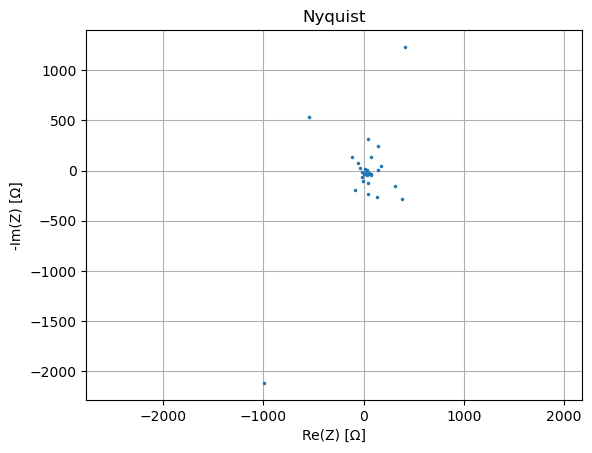

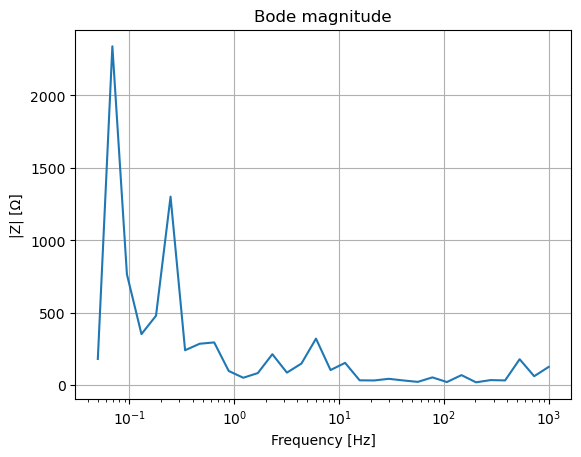

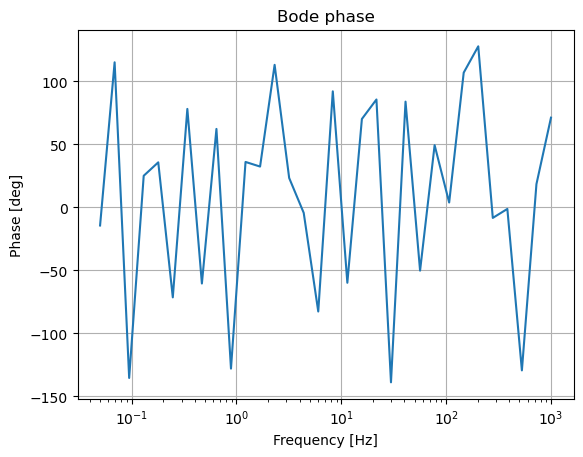

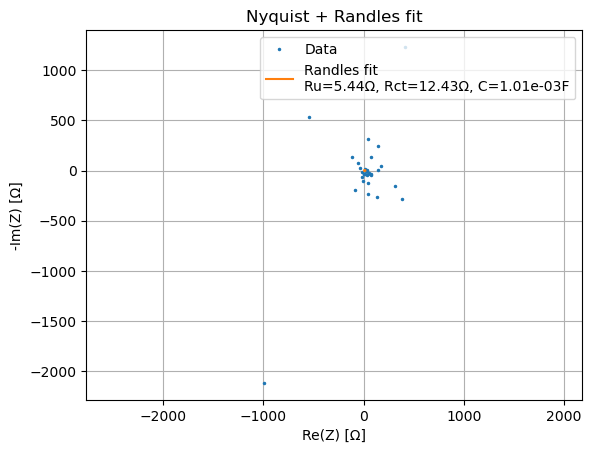

{'processed_csv': 'output/dc-100mV-ac20mV-50mHz-1kHz_20251016_152959_Traces_impedance.csv',
 'summary_txt': 'output/dc-100mV-ac20mV-50mHz-1kHz_20251016_152959_Traces_summary.txt',
 'kI': 0.1,
 'inverted': True,
 'fit': {'Ru': 5.443754208428542,
  'Rct': 12.433373593379429,
  'C': 0.0010067326151017933,
  'method': 'scipy'}}

In [28]:
infile = r"C:\Users\Lucy\OneDrive - University of Toronto\Grad\CAN\experimental results\raw data\Moku go\FRA\20251016\dc-100mV-ac20mV-50mHz-1kHz_20251016_152959_Traces.csv"
results = process_moku_fra(infile, current_range="100mA", kI_override=None)
results